# LIBRERÍAS Y DATASET

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score
from scipy.stats import chi2_contingency, ttest_ind

In [2]:
from google.colab import files
 # cargamos el dataset
uploaded = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv


In [3]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# dropeamos el id puesto que no es necesario para el analisis que hare
df.drop("customerID",axis=1, inplace=True)

# reemplazamos valores vacios por nans
df["TotalCharges"].replace(" ", np.nan, inplace=True)

# cambiamos el tipo de totalcharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], downcast='float')

In [5]:
X_train, X_test, y_train, y_test = train_test_split( df,
                                                     df['Churn'],
                                                     test_size=0.3,
                                                     random_state=0)

X_train.shape, X_test.shape

((4930, 20), (2113, 20))

# Funciones Auxiliares

## Funciones para codificar features categoricos.

```python
def ordinal_encoding(X_train, X_test, features):
def counting_encoding(X_train, X_test, features):
def ordered_integer_encoding(X_train, X_test, features, target):
def target_mean_encoding(X_train, X_test, features, target):
def weight_of_evidence_encoding(X_train, X_test, features, target):
```

In [6]:
# codifica cada valor unico en un feature con un entero unico
def ordinal_encoding(X_train, X_test, features):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    ordinal_mapping = {k:i for i,k in enumerate(X_train[feature].unique(),0)}

    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)

  return X_train_r, X_test_r

# codifica cada valor unico en un feature con su debido numero de ocurrencias
def counting_encoding(X_train, X_test, features):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:
    # creo diccionario con la suma de las ocurrencias de cada valor
    ordinal_mapping = X_train[feature].value_counts().to_dict()

    # reemplazo los valores categoricos por su ctidad de ocurrencias
    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)
  
  return X_train_r, X_test_r


# codifica cada valor unico en un feature con un entero
# si el target de acuerdo a un label en particular presenta
# una media mas elevada => dicho label obtendra un valor de entero mayor
# que otro label que tenga dicha media mas reducida.
def ordered_integer_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # agrupo por feature y calculo la media del target y ordeno de forma ascendente
    ordered_labels = X_train_r.groupby(by=feature)[target].mean().sort_values().index

    # creamos el diccionario indicando la la media de los distintos labels per feature
    ordinal_mapping = {k:i for i,k in enumerate(ordered_labels, 0)}

    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)

  return X_train_r, X_test_r

# codifica cada valor categorico en la media del target agrupando por feature
def target_mean_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # calculamos la media del target por feature y convertimos en diccionario
    ordinal_mapping = X_train_r.groupby(by=feature)[target].mean().to_dict()

    # reemplazamos los valores categoricos por la media ya calculada
    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)

  return X_train_r, X_test_r

def weight_of_evidence_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  tmp = X_train_r.copy()

  total_pos = X_train_r[target].sum()
  total_neg = len(X_train_r) - total_pos

  # non target
  tmp['non-target'] = 1 - tmp[target]

  for feature in features:
    # calculamos el % de pos-target por feature
    pos_perc = tmp.groupby([feature])[target].sum() / total_pos

    # calculamos el % de non-target por feature
    neg_perc = tmp.groupby([feature])['non-target'].sum() / total_neg

    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # calculamos el Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    ordinal_mapping = prob_tmp['woe'].to_dict()

    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping) 
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping) 

  return X_train_r, X_test_r

## Otras funciones.

```python
def dict_of_cardinalities(df, features):
```

In [7]:
# Calcula la caridnalidad para los features dados
# Devuelve un diccionario de 2-uplas
# la primer upla indica la cardinalidad
# la segunda upla indica el porcentaje de c/valor de dicho feature
def dict_of_cardinalities(df, features):
  dict_card = {}

  for feature in features:

    cardinality = df[feature].nunique()
    dict_card[feature] = cardinality , df[feature].value_counts(normalize=True)

  return dict_card

# VISUALIZACIÓN DEL DATASET

## Histogramas.

**OBS:**

* La mayoría de clientes NO son jubilados.
* El número de meses de tenencia de los empleados es mayor los primeros meses y tmb a partir del mes 65 aprox.
* Hay muchos clientes con un `MonthlyCharges` menor a 30. Esto podría ser, ya que al principio los clientes entran a la compañía con promociones y luego estas promociones se retiran.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9adecedd0>,
      dtype=object)

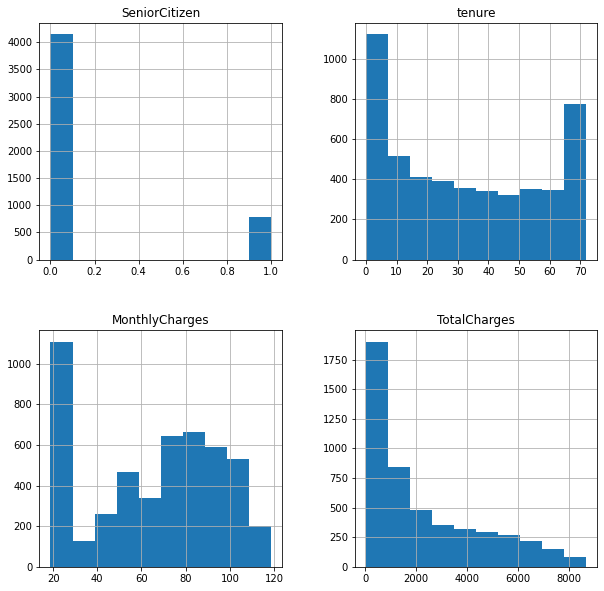

In [8]:
X_train.hist(figsize=(10,10),bins=10)

## Graficos de densidad.

In [9]:
# obtenemos los empleados "viejos" de la empresa
old_customers = X_train[X_train["tenure"] > 60]
old_customers.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,974.000000,974.000000,974.000000,974.000000
mean,0.161191,68.095483,76.107649,5190.251465
std,0.367896,3.585130,31.638318,2194.493408
min,0.000000,61.000000,19.100000,1123.650024
25%,0.000000,65.000000,55.000000,3742.637512
50%,0.000000,69.000000,84.700000,5751.625000
75%,0.000000,72.000000,104.050000,6891.437622
max,1.000000,72.000000,118.650000,8684.799805


In [10]:
# obtenemos empleados "nuevos" de la empresa
new_customers = X_train[X_train["tenure"] < 10]
new_customers.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,1308.000000,1308.000000,1308.000000,1300.000000
mean,0.150612,3.703364,56.595872,221.070526
std,0.357807,2.748708,26.338351,213.089691
min,0.000000,0.000000,18.800000,18.850000
25%,0.000000,1.000000,25.387500,69.099998
50%,0.000000,3.000000,59.175000,139.149994
75%,0.000000,6.000000,78.575000,324.212524
max,1.000000,9.000000,109.900000,970.450012


In [11]:
new_customers.shape, old_customers.shape

((1308, 20), (974, 20))

**OBS:**

Efectivamente podemos ver que clientes nuevos pagan menos que clientes viejos.

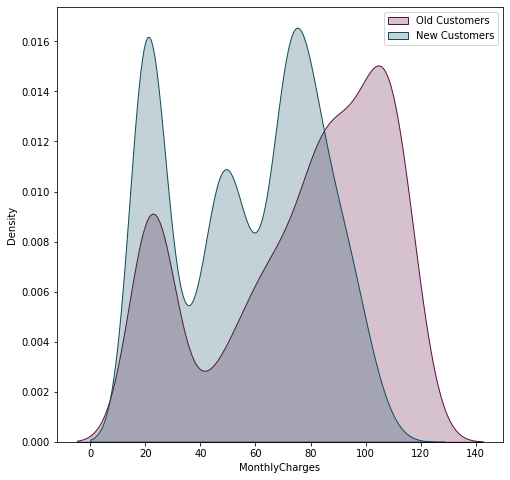

In [12]:
f, axs = plt.subplots(1,1,figsize=(8, 8))
sns.kdeplot( x="MonthlyCharges", data=old_customers, shade=True, ax=axs, color="#5f0f40", label= "Old Customers")
sns.kdeplot( x="MonthlyCharges", data=new_customers, shade=True, ax=axs, color="#0f4c5c", label= "New Customers")
axs.legend()

**OBS:** 

Pareciera haber cierta relación con los clientes jubilados y el `MonthlyCharges`, puesto que los jubilados tienden a pagar más.

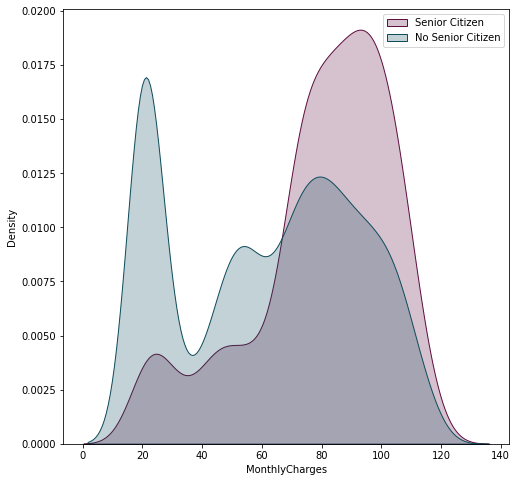

In [13]:
senior_citizen_customers = X_train[X_train["SeniorCitizen"] == 1]
no_senior_citizen_customers = X_train[X_train["SeniorCitizen"] == 0]

f, axs = plt.subplots(1,1,figsize=(8, 8))
sns.kdeplot( x="MonthlyCharges", data = senior_citizen_customers, shade = True, ax = axs, color="#5f0f40", label= "Senior Citizen")
sns.kdeplot( x="MonthlyCharges", data = no_senior_citizen_customers, shade = True, ax = axs, color="#0f4c5c", label= "No Senior Citizen")
axs.legend()

## Graficos de barras.

In [14]:
cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == np.object_]
cat_feats

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

Ploteamos gráficos de barras para cada feature categórico, contando de acuerdo al feature `Churn`.

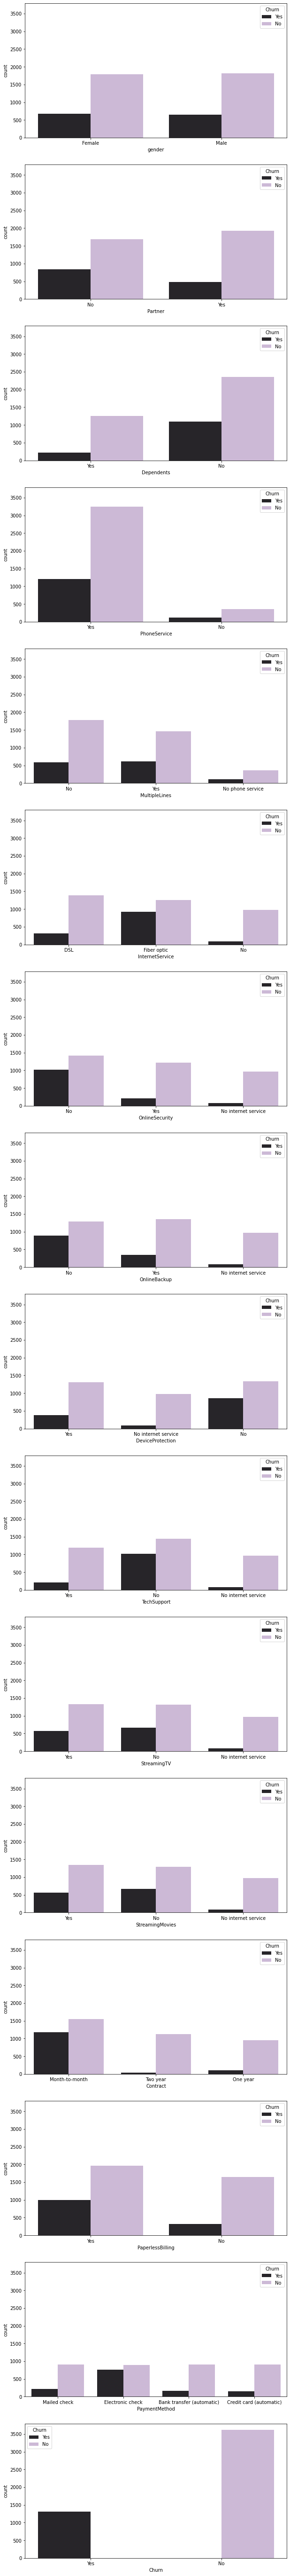

In [15]:
f, axs = plt.subplots(len(cat_feats), 1, figsize=(10, 100), sharey=True)

for i in range(len(cat_feats)):
  sns.countplot(x=cat_feats[i], hue="Churn", data = X_train, ax=axs[i], palette="dark:#cdb4db")

**Algunas OBS** Pareciera haber cierta relación de los sig. features con el target.

* `TechSupport`
* `Contract`
* `PaperlessBilling`
* `PaymentMethod`

Esta relación se puede visibilizar en los gráficos de arriba.

# SELECCION Y TRATAMIENTO DE FEATURES

## Tratamiento de variables categóricas.

Podemos ver que solo hay algunos valores nulos en el feature `TotalCharges`.
Los reemplazamos por la media de dicho feature.

In [16]:
X_train.isnull().mean()

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001623
Churn               0.000000
dtype: float64

Reemplazamos los valores nulos en `TotalCharges` por la media de dicho feature.

In [17]:
mean_total_charges = X_train["TotalCharges"].mean()

X_train["TotalCharges"] = X_train["TotalCharges"].fillna(mean_total_charges) 
X_test["TotalCharges"] = X_test["TotalCharges"].fillna(mean_total_charges) 

In [18]:
cat_feats = [feat for feat in X_train.columns if X_train[feat].dtype == np.object_]
cat_feats.remove("Churn")
cat_feats

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Cardinalidades y valores raros.

**OBS:**
* En el feature `PhoneService` tenemos 2 valores y uno presenta una frecuencia del 90%.

No poseemos features categoricos con muchas cardinalidades, ni tmpoco features con valores que aparezcan con una frecuencia muy baja.

In [19]:
dict_of_cardin_r = dict_of_cardinalities(X_train, cat_feats)
for k in dict_of_cardin_r:
  print(f"Feature: {k} With cardinality: {dict_of_cardin_r[k][0]} \n{dict_of_cardin_r[k][1:]}\n")
  print("========================================")

Feature: gender With cardinality: 2 
(Male      0.500203
Female    0.499797
Name: gender, dtype: float64,)

Feature: Partner With cardinality: 2 
(No     0.512576
Yes    0.487424
Name: Partner, dtype: float64,)

Feature: Dependents With cardinality: 2 
(No     0.698986
Yes    0.301014
Name: Dependents, dtype: float64,)

Feature: PhoneService With cardinality: 2 
(Yes    0.903245
No     0.096755
Name: PhoneService, dtype: float64,)

Feature: MultipleLines With cardinality: 3 
(No                  0.481542
Yes                 0.421704
No phone service    0.096755
Name: MultipleLines, dtype: float64,)

Feature: InternetService With cardinality: 3 
(Fiber optic    0.440568
DSL            0.346045
No             0.213387
Name: InternetService, dtype: float64,)

Feature: OnlineSecurity With cardinality: 3 
(No                     0.495943
Yes                    0.290669
No internet service    0.213387
Name: OnlineSecurity, dtype: float64,)

Feature: OnlineBackup With cardinality: 3 
(No     

### Categorical encoding.

Los aprouchs que aplicaremos para el encoding de features categóricos serán:
* Ordinal encoding.
* Ordered integer encoding.
* Count encoding.
* Mean encoding.
* Weight of evidence.

**Ordinal Encoding**

In [20]:
# codificamos la variable a predecir
X_train["Churn"] = np.where(X_train["Churn"] == "Yes", 1, 0)
X_test["Churn"] = np.where(X_test["Churn"] == "Yes", 1, 0)

y_train = X_train["Churn"]
y_test = X_test["Churn"]

In [21]:
X_train_OE, X_test_OE = ordinal_encoding(X_train, X_test, cat_feats)

**Ordered Integer Encoding**

In [22]:
X_train_OIE, X_test_OIE = ordered_integer_encoding(X_train, X_test, cat_feats, "Churn")

**Count Encoding**

In [23]:
X_train_CE, X_test_CE = counting_encoding(X_train, X_test, cat_feats)

**Mean Encoding**

In [24]:
X_train_TME, X_test_TME = target_mean_encoding(X_train, X_test, cat_feats, "Churn")

**Weight of Evidence Encoding**

In [25]:
X_train_WOEE, X_test_WOEE = weight_of_evidence_encoding(X_train, X_test, cat_feats, "Churn")

### Categorical encoding performance

Analizamos los diferentes aprouchs de codificación utilizando RandomForest y LogisticRegression.

In [26]:
def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
  
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
  

def run_logistic(X_train, X_test, y_train, y_test):

    lr = LogisticRegression(max_iter=100,random_state=0)
    lr.fit(X_train, y_train)

    print('Train set')
    pred = lr.predict_proba(X_train)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = lr.predict_proba(X_test)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

**RANDOM FOREST**

In [27]:
# ONE HOT ENCODING
run_randomForests(X_train_OE[cat_feats], X_test_OE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.8225601889309221
Test set
Random Forests roc-auc: 0.8086665971159641


In [28]:
# COUNTING ENCODING
run_randomForests(X_train_CE[cat_feats], X_test_CE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.8277137583830528
Test set
Random Forests roc-auc: 0.8153591134603793


In [29]:
# ORDERED INTEGER ENCODING
run_randomForests(X_train_OIE[cat_feats], X_test_OIE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.8281149338186686
Test set
Random Forests roc-auc: 0.8154251866277183


In [30]:
# TARGET MEAN ENCODING
run_randomForests(X_train_TME[cat_feats], X_test_TME[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.8281149338186686
Test set
Random Forests roc-auc: 0.8154251866277183


In [31]:
# WEIGHT OF EVIDENCE ENCODING
run_randomForests(X_train_WOEE[cat_feats], X_test_WOEE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.8281149338186686
Test set
Random Forests roc-auc: 0.8154251866277183


**LOGISTIC REGRESSION**

In [32]:
# ONE HOT ENCODING
run_logistic(X_train_OE[cat_feats], X_test_OE[cat_feats], y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8241128514069735
Test set
Logistic Regression roc-auc: 0.8045874484165623


In [33]:
# COUNTING ENCODING
run_logistic(X_train_CE[cat_feats], X_test_CE[cat_feats], y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8326015596220708
Test set
Logistic Regression roc-auc: 0.8156657161403996


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [34]:
# ORDERED INTEGER ENCODING
run_logistic(X_train_OIE[cat_feats], X_test_OIE[cat_feats], y_train, y_test)

Train set
Logistic Regression roc-auc: 0.831562351241289
Test set
Logistic Regression roc-auc: 0.8166150832290073


In [35]:
# TARGET MEAN ENCODING
run_logistic(X_train_TME[cat_feats], X_test_TME[cat_feats], y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8337054228490016
Test set
Logistic Regression roc-auc: 0.8186175638707285


In [36]:
# WEIGHT OF EVIDENCE ENCODING
run_logistic(X_train_WOEE[cat_feats], X_test_WOEE[cat_feats], y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8348315736001333
Test set
Logistic Regression roc-auc: 0.8202409931840312


**OBS:** Podemos ver que el mejor aprouch para codificar los valores categóricos es el de Weight of evidence conjunto a un modelo de regresión logística.

## Feature selection.

Aplicaremos las mediciones estadísticas de: 

* Ji-square test (features categoricos).
* T-student test.
* Univariate roc-auc (features numericos).

### Ji-square test.

Determinamos la dependencia de los features categoricons con el target.

<h2>$ χ^2 = \sum_{i=1}^{n} \frac{(observed_{i} - expected_{i})^2}{expected_{i}}$<h2/>

Una vez calculado dicha sumatoria, podremos calcular el $p$-valor.

Nuestras hipotesis:

$H_0$ = Las variables son independientes. NO existe dependencia entre Attrition y la variable que se está probando.

$H_1$ = Las variables NO SON independientes. SI existe dependencia entre Attrition y la variable que se está probando.

In [37]:
# calculamos los features categoricos y discretos
feat_for_test = [feat for feat in X_train.columns if X_train[feat].dtype == np.object_ or X_train[feat].nunique() < 10]
feat_for_test.remove("Churn")
feat_for_test

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [38]:
chi_statistic=[]
p_val=[]
feats_rm = []

for feat in feat_for_test:
  # calculamos la tabla de contingencia
  observed = pd.crosstab(index=X_train["Churn"], columns=X_train[feat])
  
  # obtenemos los estadisticos a partir de la tabla de contingencia
  stat, p, dof, expected=chi2_contingency(observed)
  chi_statistic.append(stat)
  p_val.append(p)

  # obtenemos los features independientes
  if p >= 0.05:
      print("Attrition y {} son independientes (p-value = {:.2f}).\n".format(feat,p))
      feats_rm.append(feat)

# creamos el dataframe con los resultados
chi_df = pd.DataFrame()
chi_df["Feature"] = feat_for_test
chi_df["Chi_Statistic"] = chi_statistic
chi_df["P_value"] = p_val

# removemos los features independientes
chi_df = chi_df[chi_df["P_value"] < 0.05]

# guardamos el nombre de los features resultantes
feat_w_high_depAttrition = chi_df["Feature"].values

# oredenamos segun el p-valor
chi_df.sort_values(by="P_value", ascending=True, inplace=True)
chi_df

Attrition y gender son independientes (p-value = 0.45).

Attrition y PhoneService son independientes (p-value = 0.16).



,Feature,Chi_Statistic,P_value
13,Contract,870.121511,1.136356e-189
7,OnlineSecurity,580.829899,7.488416e-127
10,TechSupport,558.486545,5.323383e-122
6,InternetService,514.527398,1.869800e-112
15,PaymentMethod,487.920338,1.979004e-105
8,OnlineBackup,445.104879,2.221793e-97
9,DeviceProtection,373.507074,7.833745e-82
12,StreamingMovies,252.833809,1.252668e-55
11,StreamingTV,249.616926,6.257101e-55
14,PaperlessBilling,174.755767,6.769257e-40


### T-Student test.

Para comparar promedios entre features y si existe promedios similares o distintos entre los features, utilizaremos la prueba de la T-Student.

<h2>$t = \frac{ |\overline{X_{1}} - \overline{X_{2}}| }{ \sqrt[]{ \frac{σ_{1}^2}{n_{1}} - \frac{σ_{2}^2}{n_{2}}  }}$<h2/>

Donde $\ n_{1}$ y $\ n_{2}$ son el numero de obs. Una vez calculado dicha sumatoria, podremos calcular el $p$-valor.

Nuestras hipótesis:

$H_0$ = No hay una diferencia estadística significante entre las variables* (con respecto a la media) $\therefore$ las variables tienen medias similares.

$H_1$ = Si hay una diferencia estadística significante entre las variables*
$\therefore$ las variables NO tienen medias similares.


$\therefore$ si el $p$-valor obtenido es **menor** que 0.05 $⇒$ hay evidencia suficiente para aceptar $H_1$.

ie que hay una diferencia en la media de `TotalCharges` entre los clientes que abandonan el servicio y los que no.

In [39]:
p_values = []
t_stats = []
features_to_test = ["TotalCharges"]

for feat in features_to_test:
  feat_1 = X_train[X_train["Churn"] == 1][feat]
  feat_2 = X_train[X_train["Churn"] == 0][feat]

  t_stat, p_value = ttest_ind(feat_1, feat_2)

  p_values.append(p_value)
  t_stats.append(t_stat)

# creamos el dataframe con los resultados
t_st_df = pd.DataFrame()
t_st_df["Feature"] = features_to_test
t_st_df["T_StudentStat"] = t_stats
t_st_df["P_value"] = p_values

# oredenamos segun el p-valor
t_st_df.sort_values(by="P_value", ascending=True, inplace=True)
t_st_df

,Feature,T_StudentStat,P_value
0,TotalCharges,-15.084382,2.683292e-50


### Univariate roc-auc.

Determinaremos la importancia de los features numercios CONTINUOS mediante el score roc-auc.

* 1) Construimos un rfc por feature, para predecir el objetivo.
* 2) Hacemos predicciones utilizando el árbol de decisiones y el feature mencionada.
* 3) Medimos el rendimiento de esa predicción, ya sea el roc-auc, el mse o cualquier otra métrica.
* 4) Clasificamos las funciones según la métrica de aprendizaje automático (roc-auc o mse)
* 5) Seleccionamos los features de mayor rango.

In [40]:
num_feats = [feat for feat in X_train.columns if (X_train[feat].dtype != np.object_ and X_train[feat].nunique() >= 10)]
num_feats

['tenure', 'MonthlyCharges', 'TotalCharges']

In [41]:
roc_values = []

for feature in num_feats:

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train[[feature]], y_train)

    y_scored = clf.predict_proba(X_test[[feature]])

    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
roc_values

[0.7247165808874669, 0.6068895766680577, 0.5650942412018363]

Text(0, 0.5, 'roc-auc')

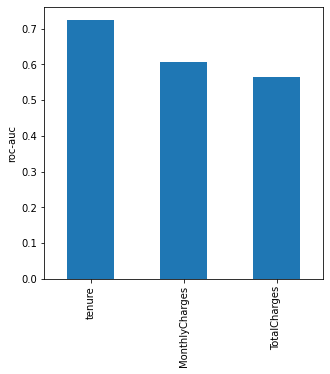

In [42]:
roc_values = pd.Series(roc_values)
roc_values.index = num_feats
roc_values.sort_values(ascending=False).plot.bar(figsize=(5, 5))
plt.ylabel('roc-auc')

In [43]:
feat_w_high_roc_auc = roc_values[roc_values > 0.5].index
feat_w_high_roc_auc

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

# ENTRENAMIENTO Y EVALUACIÓN DE MODELOS DE ML.

## Data Balancing

In [44]:
selected_features = feat_w_high_roc_auc.tolist() + feat_w_high_depAttrition.tolist()

In [45]:
from imblearn.over_sampling import SMOTE 

over = SMOTE(sampling_strategy = 1)
X_train_tmp, y_train_tmp = over.fit_resample(X_train_WOEE[selected_features], y_train)

## Escalar datos.

In [46]:
scaler = MinMaxScaler()

X_train_WOEE_scaled = scaler.fit_transform(X_train_tmp)
X_test_WOEE_scaled = scaler.transform(X_test_WOEE[selected_features])

## Modelado.

Declararemos 3 modelos de regresión logística distintos y analizaremos su performance.

Entrenaremos los sig. modelos:
* Regresión logística.
* Random forest.
* XGBClassifier.

In [47]:
def model_(classifier, X_train, X_test, y_train, y_test):
  classifier.fit(X_train, y_train)

  pred = classifier.predict(X_train)

  print("Train set")

  print(f"{classifier} roc-auc: {roc_auc_score(y_train, pred)}")

  print("Test set")

  pred = classifier.predict(X_test)

  print(f"{classifier} roc-auc: {roc_auc_score(y_test, pred)}")

  print(f"Acurracy {100*accuracy_score(y_test, pred)}")

  print("-------------------------")
  print((classification_report(y_test, pred)))

  cm = confusion_matrix(y_test, pred)
  sns.heatmap(cm, annot=True)



**LOGISTIC REGRESSION**

Train set
LogisticRegression(C=1000, class_weight='balanced', random_state=0,
                   solver='liblinear') roc-auc: 0.7823741007194245
Test set
LogisticRegression(C=1000, class_weight='balanced', random_state=0,
                   solver='liblinear') roc-auc: 0.7531205081837993
Acurracy 74.49124467581638
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1560
           1       0.51      0.77      0.61       553

    accuracy                           0.74      2113
   macro avg       0.70      0.75      0.71      2113
weighted avg       0.80      0.74      0.76      2113



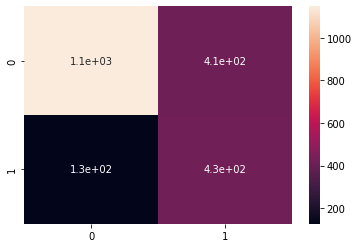

In [55]:
lr = LogisticRegression(C=1000, class_weight='balanced', random_state=0,
                        solver='liblinear')

model_(lr, X_train_WOEE_scaled, X_test_WOEE_scaled, y_train_tmp, y_test)

**RANDOM FOREST**

Train set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.8240177089097952
Test set
RandomForestClassifier(max_depth=4, random_state=0) roc-auc: 0.7397105531599203
Acurracy 75.95835305253195
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1560
           1       0.53      0.70      0.60       553

    accuracy                           0.76      2113
   macro avg       0.71      0.74      0.72      2113
weighted avg       0.79      0.76      0.77      2113



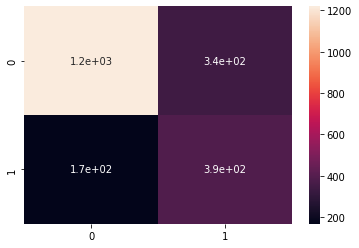

In [49]:
rfc = RandomForestClassifier(max_depth = 4,random_state = 0)

model_(rfc, X_train_WOEE_scaled, X_test_WOEE_scaled, y_train_tmp, y_test)

**XGBClassifier**

Train set
XGBClassifier(learning_rate=0.01, n_estimators=1000) roc-auc: 0.8705035971223021
Test set
XGBClassifier(learning_rate=0.01, n_estimators=1000) roc-auc: 0.7253529698149952
Acurracy 78.75059157595835
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1560
           1       0.59      0.59      0.59       553

    accuracy                           0.79      2113
   macro avg       0.73      0.73      0.73      2113
weighted avg       0.79      0.79      0.79      2113



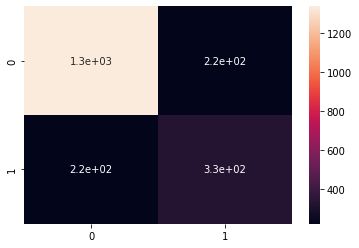

In [50]:
xgb = XGBClassifier(random_state=0,learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
model_(xgb, X_train_WOEE_scaled, X_test_WOEE_scaled, y_train_tmp, y_test)

**Modeling Resume**

|PREDICT|ML Algorithm|ROC AUC TRAIN SET|ROC AUC TEST SET|PRECISION|RECALL|
|-------|------------|-----------------|----------------|---------|------|
|0      |Log Regres  |0.78             |0.75            |0.90     |0.73  | 
|1      |Log Regres  |0.78             |0.75            |0.51     |0.78  | 
|0      |RandomForest|0.82             |0.73            |0.88     |0.78  | 
|1      |RandomForest|0.82             |0.73            |0.52     |0.69  | 
|0      |XGBClassif  |0.87             |0.73            |0.86     |0.86  | 
|1      |XGBClassif  |0.87             |0.73            |0.60     |0.59  | 


**CONCLUSIÓN**

A partir de los dos modelos entrenados podemos concluir que:

* **LogisticRegression** NO posee over-fitting. El modelo presenta una precisión del 74% (menor a los otros dos modelos), el modelo a la hora de predecir los clientes que se marchan predice correctamente el 51% de ellos, **PERO** podemos ver que **la métrica de recall es bastante alta comparada a los otros dos modelos, llegando casi a un 80%**, ie que el modelo **es capaz de capturar el 80% de los clientes que se marchan**, por ende a pesar de la precisión parece ser mucho mejor modelo que el rfc para este particular problema.

* **RandomForest** tiende a tener over-fitting (se puede apreciar gracias a la metrica roc-auc). El modelo presenta una precisión del 75%, además **posee un valor de recall del 70%**, ie que es capaz de capturar el 70% de los clientes que se  marchan.

* **XGB** es el modelo que **mas over-fitting presenta**. Dicho modelo **tiene la mejor precision de los 3 llegando casi al 80%** **PERO** la performance del modelo se ve drasticamente deteriorada si se tiene en cuenta **la metrica de recall, llegando al 60%**, la mas baja de los 3, ie que **el 40% de los empleados que se marchan el modelo no es capaz de capturarlos.**


Dicho esto la regresión logística pareciera ser el mejor modelo para responder el problema de deserción de clientes.

A su vez podemos ver que los features más importantes a la hora de determinar si un cliente se queda o se marcha son:

* Tenuere
* TotalCharges
* Contract
* InternetService
* StreamingMovies



In [51]:
feature_importance = pd.DataFrame()
feature_importance["Feature"] = selected_features
feature_importance["Coef"] = np.abs(lr.coef_.flatten())
feature_importance.sort_values(by="Coef", ascending=False).head()

,Feature,Coef
0,tenure,4.261063
2,TotalCharges,3.279972
14,Contract,1.478731
7,InternetService,1.360416
12,StreamingTV,1.281861
